# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **learning-rate control (with Reduce on Plateau)**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model. 

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


In [6]:
!pip install numpy matplotlib scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 30.3 MB/s  0:00:11m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 56.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 53.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 48.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 47.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 55.2 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24/24 [tensorflow]4 [tensorflow]]data-server]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [kagglehub]/4 [kagglehub]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


## 1. Setup and Data Loading


In [7]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


### Dataset Prototype Control (Important)

To speed up development and debugging, you will use a **balanced prototype version of the Intel training dataset** while building and testing your code.

* **During development:**
  Set `PROTO_TOTAL` to an integer (for example, `1400`) to train on a balanced subset of the training data
  (≈ 10% of the full Intel training set).

* **For your final runs:**
  Set `PROTO_TOTAL = None` (or `0`) to train on the **full training dataset**.

#### Notes

* This setting affects the **training pool** of images used to build `train_ds` and `val_ds`.
* The **validation fraction** (`VAL_FRAC`) is unchanged, but the **validation set will be smaller** when you use a prototype training pool.
* The **test set is unchanged** and is always evaluated on the full test dataset.

#### Before You Submit

Before submitting your notebook, make sure that:

* [ ] `PROTO_TOTAL` is set to `None` (or `0`) so the model is trained on the **full training dataset**
* [ ] Your notebook runs **top to bottom without errors**
* [ ] Training completes successfully using the full dataset

Submissions that leave `PROTO_TOTAL` set to a prototype value will **not** receive full credit.


In [8]:
# Prototype control:
#   - Set PROTO_TOTAL to an integer (e.g., 1400) to use a balanced subset (~10% of Intel train)
#   - Set PROTO_TOTAL to None (or 0) to use the full training set

PROTO_TOTAL = 1400   # <-- change to None for full dataset

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [9]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Training and testing sets already defined, accessed here as global variables

In [10]:
# Uses globals: train_ds, val_ds, test_ds

def train_and_test(model, 
                   epochs=500,
                   lr_schedule=1e-3,
                   optimizer="Adam",
                   title="Learning Curves",
                   batch_size=64,  # kept for API compatibility; ignored if datasets are batched
                   use_early_stopping=True,
                   patience=8,
                   min_delta=1e-4,
                   callbacks=None,
                   verbose=1,
                   return_history=False):

    print(f"\n{title}\n")

    # Choose optimizer
    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer  # assume already an optimizer instance

    # Compile
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )

    extra_cbs = callbacks or []
    cbs = ([early_stop] if use_early_stopping else []) + extra_cbs

    start = time.time()

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=verbose
    )

    # Best epoch consistent with EarlyStopping monitor
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_acc   = history.history["val_accuracy"][best_epoch]

    plot_learning_curves(history, title=title)

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end - start))

    if return_history:
        return history


### Load the Intel Image Classification Dataset  



In [11]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

100%|██████████| 346M/346M [00:02<00:00, 126MB/s]  

Extracting files...


In [12]:

AUTOTUNE = tf.data.AUTOTUNE

def list_files_and_labels(directory, class_names=None, exts=(".jpg", ".jpeg", ".png")):
    """
    Returns:
      filepaths: np.array[str]
      labels:    np.array[int32]
      class_names_used: list[str] in deterministic order
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # keep only classes that exist in this directory, preserve given order
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    filepaths = []
    labels = []

    for cname in class_names:
        folder = os.path.join(directory, cname)
        for fname in sorted(os.listdir(folder)):  # deterministic within class
            if fname.lower().endswith(exts):
                filepaths.append(os.path.join(folder, fname))
                labels.append(class_to_idx[cname])

    return np.array(filepaths), np.array(labels, dtype=np.int32), class_names


def stratified_split_indices(y, val_frac=0.2, seed=42):
    """
    Deterministic stratified split over indices.
    Returns: train_idx, val_idx (np arrays)
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)

    train_idx_list = []
    val_idx_list = []

    classes = np.unique(y)
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)
        n_val = int(np.floor(len(idx) * val_frac))
        val_idx_list.append(idx[:n_val])
        train_idx_list.append(idx[n_val:])

    train_idx = np.concatenate(train_idx_list)
    val_idx   = np.concatenate(val_idx_list)

    # shuffle each split deterministically so batches mix classes
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    return train_idx, val_idx


def balanced_subset_indices(y, total=None, per_class=None, seed=42, allow_smaller=True):
    """
    Choose a balanced subset of indices.

    Specify exactly one of:
      - total: desired total number of samples across all classes (realized = floor(total/k)*k)
      - per_class: desired samples per class

    Returns:
      subset_idx: np.array of indices into y
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    classes = np.unique(y)
    k = len(classes)

    if (total is None) == (per_class is None):
        raise ValueError("Specify exactly one of total or per_class.")

    if per_class is None:
        per_class = int(total // k)  # balanced; realized total = per_class * k

    chosen = []
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)

        if len(idx) < per_class:
            if not allow_smaller:
                raise ValueError(f"Class {c} has only {len(idx)} items, need {per_class}.")
            take = len(idx)
        else:
            take = per_class

        chosen.append(idx[:take])

    subset_idx = np.concatenate(chosen)
    rng.shuffle(subset_idx)  # mix classes deterministically
    return subset_idx


def make_image_dataset(filepaths, labels, img_size=(150, 150), batch_size=32,
                       shuffle=False, seed=42, cache_to_disk=None):
    """
    Builds a tf.data.Dataset that loads images lazily from disk.
    - filepaths: np array of strings
    - labels:    np array of int32
    """
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if shuffle:
        # shuffle file references (cheap), not image tensors
        ds = ds.shuffle(buffer_size=len(filepaths), seed=seed, reshuffle_each_iteration=True)

    def _load_and_preprocess(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size, method="bilinear")
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if cache_to_disk is not None:
        ds = ds.cache(cache_to_disk)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


# -------------------------
# Intel dataset loading (with optional balanced prototype subset)
# -------------------------

IMG_SIZE    = (150, 150)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE  = 32
VAL_FRAC    = 0.2
SEED        = random_seed  # use your existing seed

# 1) List train files/labels deterministically
train_files_all, train_labels_all, class_names = list_files_and_labels(train_dir)
num_classes = len(class_names)

# 2) Optional: take a balanced prototype subset (no images loaded yet)
if PROTO_TOTAL is not None and PROTO_TOTAL > 0:
    proto_idx = balanced_subset_indices(train_labels_all, total=PROTO_TOTAL, seed=SEED)
    train_files  = train_files_all[proto_idx]
    train_labels = train_labels_all[proto_idx]
else:
    train_files  = train_files_all
    train_labels = train_labels_all

# Report realized size (balanced)
per_class = len(train_files) // num_classes
print(f"Train pool: {len(train_files)} images ({per_class} per class), classes={num_classes}")

# 3) Stratified deterministic split of indices (still no images loaded)
train_idx, val_idx = stratified_split_indices(train_labels, val_frac=VAL_FRAC, seed=SEED)

# 4) Slice file lists for train/val
files_train = train_files[train_idx]
y_train     = train_labels[train_idx]
files_val   = train_files[val_idx]
y_val       = train_labels[val_idx]

print(f"Split sizes: train={len(files_train)}, val={len(files_val)} (VAL_FRAC={VAL_FRAC})")

# 5) Build datasets (lazy image loading)
train_ds = make_image_dataset(files_train, y_train, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                              cache_to_disk=None)  # or "/tmp/train_cache"

val_ds   = make_image_dataset(files_val, y_val, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=False,
                              cache_to_disk=None)  # or "/tmp/val_cache"

# 6) Test set: keep same class mapping as train
test_files, test_labels, _ = list_files_and_labels(test_dir, class_names=class_names)

# Possible but not recommended: prototype the test set too (balanced). Set to None for full test.
PROTO_TEST_TOTAL = None
if PROTO_TEST_TOTAL is not None and PROTO_TEST_TOTAL > 0:
    test_idx = balanced_subset_indices(test_labels, total=PROTO_TEST_TOTAL, seed=SEED)
    test_files  = test_files[test_idx]
    test_labels = test_labels[test_idx]
    print(f"Test pool: {len(test_files)} images ({len(test_files)//num_classes} per class)")

test_ds = make_image_dataset(test_files, test_labels, img_size=IMG_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False,
                             cache_to_disk=None)


Train pool: 1398 images (233 per class), classes=6
Split sizes: train=1122, val=276 (VAL_FRAC=0.2)


2026-02-20 19:21:05.603442: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Examine The Dataset

In [13]:

def show_counts_from_labels(name, labels, class_names):
    c = Counter(labels.tolist())
    counts = {class_names[k]: c.get(k, 0) for k in range(len(class_names))}
    print(f"{name} per-class counts:", counts)

print("class_names:", class_names)
print("train examples:", len(files_train), "val examples:", len(files_val), "test examples:", len(test_files))

show_counts_from_labels("train", y_train, class_names)
show_counts_from_labels("val",   y_val,   class_names)
show_counts_from_labels("test",  test_labels, class_names)


class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train examples: 1122 val examples: 276 test examples: 3000
train per-class counts: {'buildings': 187, 'forest': 187, 'glacier': 187, 'mountain': 187, 'sea': 187, 'street': 187}
val per-class counts: {'buildings': 46, 'forest': 46, 'glacier': 46, 'mountain': 46, 'sea': 46, 'street': 46}
test per-class counts: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


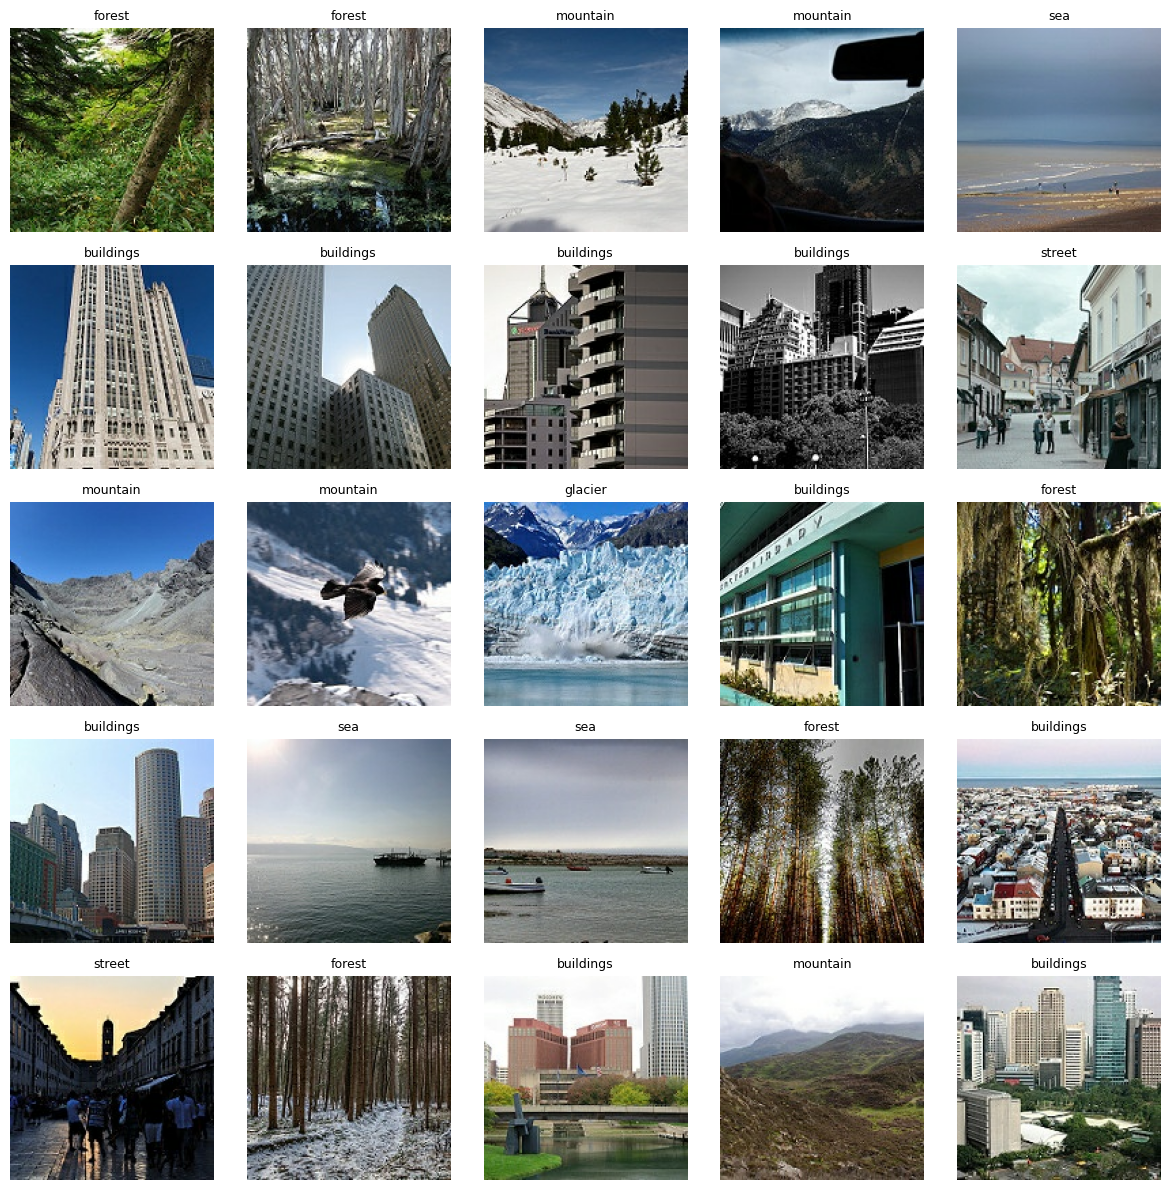

In [14]:
# Show 25 sample images

plt.figure(figsize=(12, 12))

# Take one batch from the dataset
images, labels = next(iter(train_ds))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Learning Rate Schedulers

In [15]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`. 

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).

> **NOTE:** MobileNetV2 ImageNet weights were trained at 224×224.
> We use 150×150 for faster training; this is valid because the backbone is fully convolutional
> when include_top=False (weights transfer to different input sizes).
>
> You may safely ignore the warning: "UserWarning: `input_shape` is undefined or non-square, ...."

In [16]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=INPUT_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base
    
base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

/tmp/ipykernel_9058/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [17]:
# Ha, this is very long!

# base.summary()

/tmp/ipykernel_9058/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Model Baseline

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.6176 - loss: 1.0293 - val_accuracy: 0.7935 - val_loss: 0.5939
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.8485 - loss: 0.4067 - val_accuracy: 0.8478 - val_loss: 0.4115
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.8975 - loss: 0.2980 - val_accuracy: 0.8732 - val_loss: 0.3823
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.9127 - loss: 0.2519 - val_accuracy: 0.8442 - val_loss: 0.3569
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.9394 - loss: 0.2089 - val_accuracy: 0.8442 - val_loss: 0.3557
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9421 - loss: 0.1876 - val_accuracy: 0.8551 - val_loss: 0.3637
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9510 - loss: 0.1649 - val_accuracy: 0.8623 - val_loss: 0.3497
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9545 - loss

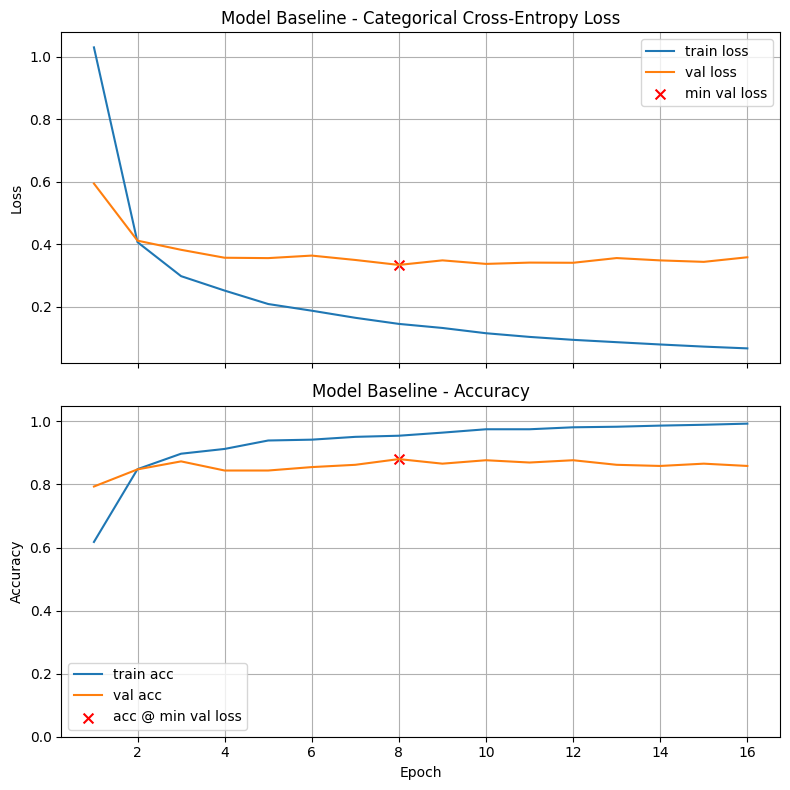

Final Training Loss:            0.0671
Final Training Accuracy:        0.9929
Final Validation Loss:          0.3584
Final Validation Accuracy:      0.8587
Minimum Validation Loss:        0.3339 (Epoch 8)
Validation Accuracy @ Min Loss: 0.8804

Test Loss: 0.3456
Test Accuracy: 0.8740

Validation-Test Gap (accuracy): 0.006435

Execution Time: 00:02:27


In [18]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')  # use your Intel num_classes (6)
])

train_and_test(model_baseline, title="Model Baseline")

### Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled(trainable=False)  # MobileNetV2(include_top=False, pooling="avg")
```

This backbone already applies **Global Average Pooling** and outputs a **1280-D** feature vector per image.
Do **not** unfreeze any backbone layers and do **not** add another pooling layer.

### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate:** fixed LR
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads.
5. **Answer the graded questions.**

### Notes / Constraints

* With `pooling="avg"`, the head receives a tensor of shape **(None, 1280)** → **do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.


In [ ]:
# Your code here; add as many cells as you need

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

INPUT_SHAPE = (150, 150, 3)
NUM_CLASSES = 6

# ------------------------------------------------------------
# 1) Frozen MobileNetV2 base (pooled features)
# ------------------------------------------------------------
base = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling="avg"               # IMPORTANT: produces (None, 1280)
)
base.trainable = False          # MUST stay frozen

# ------------------------------------------------------------
# 2) HEAD DESIGN #1: Deep MLP + BN + Dropout + L2
# ------------------------------------------------------------
def build_head_v1(l2=1e-4, d1=0.5, d2=0.4):
    x = base.output  # (None, 1280)

    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(d1)(x)

    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(d2)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(base.input, out, name="frozen_mnv2_head_v1")

# ------------------------------------------------------------
# 3) HEAD DESIGN #2: Bottleneck -> Wide + Dropout (lighter reg)
# ------------------------------------------------------------
def build_head_v2(l2=5e-5, d1=0.4, d2=0.5):
    x = base.output

    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(d1)(x)

    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(d2)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(base.input, out, name="frozen_mnv2_head_v2")

# ------------------------------------------------------------
# 4) HEAD DESIGN #3: Residual MLP block (often strongest)
# ------------------------------------------------------------
def build_head_v3(l2=1e-4, d=0.4):
    x = base.output
    shortcut = x  # (None, 1280)

    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(d)(x)

    # Project back to 1280 so we can add residual
    x = layers.Dense(1280, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Dropout(d)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(base.input, out, name="frozen_mnv2_head_v3")

# ------------------------------------------------------------
# 5) Callbacks
# ------------------------------------------------------------
def make_callbacks(use_rlrop=True, es_patience=5, rlrop_patience=3):
    cb = [
        callbacks.EarlyStopping(
            monitor="val_loss",
            patience=es_patience,
            restore_best_weights=True,
            verbose=1
        )
    ]
    if use_rlrop:
        cb.append(
            callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=rlrop_patience,
                min_lr=1e-6,
                verbose=1
            )
        )
    return cb

# ------------------------------------------------------------
# 6) Train helper (FOR SPARSE LABELS: y shape (B,))
# ------------------------------------------------------------
def compile_and_train(model, train_ds, val_ds, lr=5e-4,
                      use_rlrop=True, es_patience=5, rlrop_patience=3,
                      epochs=25):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=make_callbacks(use_rlrop=use_rlrop,
                                 es_patience=es_patience,
                                 rlrop_patience=rlrop_patience),
        verbose=1
    )
    best_val_acc = max(hist.history.get("val_accuracy", [0.0]))
    best_val_loss = min(hist.history.get("val_loss", [float("inf")]))
    return hist, best_val_acc, best_val_loss

# ------------------------------------------------------------
# 7) Run 3 Experiments (different hyperparams)
# ------------------------------------------------------------
results = []

# EXP 1: Head v1 — moderate LR + RLROP ON
print("\n====================")
print("Training Head V1 ...")
print("====================")
model1 = build_head_v1(l2=1e-4, d1=0.5, d2=0.4)
hist1, acc1, loss1 = compile_and_train(
    model1, train_ds, val_ds,
    lr=5e-4,
    use_rlrop=True,
    es_patience=5,
    rlrop_patience=3,
    epochs=25
)
results.append(("head_v1", acc1, loss1, model1))

# EXP 2: Head v2 — higher LR + RLROP OFF (fixed LR)
print("\n====================")
print("Training Head V2 ...")
print("====================")
model2 = build_head_v2(l2=5e-5, d1=0.4, d2=0.5)
hist2, acc2, loss2 = compile_and_train(
    model2, train_ds, val_ds,
    lr=1e-3,
    use_rlrop=False,
    es_patience=6,
    rlrop_patience=3,
    epochs=25
)
results.append(("head_v2", acc2, loss2, model2))

# EXP 3: Head v3 — lower LR + RLROP ON + more epochs
print("\n====================")
print("Training Head V3 ...")
print("====================")
model3 = build_head_v3(l2=1e-4, d=0.4)
hist3, acc3, loss3 = compile_and_train(
    model3, train_ds, val_ds,
    lr=1e-4,
    use_rlrop=True,
    es_patience=7,
    rlrop_patience=3,
    epochs=30
)
results.append(("head_v3", acc3, loss3, model3))

# ------------------------------------------------------------
# 8) Compare + Evaluate Best on test_ds (if available)
# ------------------------------------------------------------
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

print("\n===== COMPARISON (sorted by best val_accuracy) =====")
for name, best_acc, best_loss, m in results_sorted:
    print(f"{name:7s} | best_val_acc={best_acc:.4f} | best_val_loss={best_loss:.4f} | params={m.count_params():,}")

best_name, _, _, best_model = results_sorted[0]
print("\nBest head:", best_name)

if "test_ds" in globals():
    print("\nEvaluating best model on test_ds ...")
    test_vals = best_model.evaluate(test_ds, verbose=1)
    print(dict(zip(best_model.metrics_names, test_vals)))

/tmp/ipykernel_9058/1950931919.py:24: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(



Training Head V1 ...
Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.6328 - loss: 1.1788 - val_accuracy: 0.7464 - val_loss: 0.8239 - learning_rate: 5.0000e-04
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8503 - loss: 0.5246 - val_accuracy: 0.8732 - val_loss: 0.4984 - learning_rate: 5.0000e-04
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.8832 - loss: 0.4158 - val_accuracy: 0.8406 - val_loss: 0.4993 - learning_rate: 5.0000e-04
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.8930 - loss: 0.3961 - val_accuracy: 0.8768 - val_loss: 0.4639 - learning_rate: 5.0000e-04
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.9189 - loss: 0.3224 - val_accuracy: 0.8732 - val_loss: 0.4739 - learning_rate: 5.0000e-04
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9242 - loss: 0.3205 - val_accuracy: 0.8587 - val_loss: 0.5138 - learning_rate: 5.0000e-04
Epoch 7/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.

**Your paragraph here (5pts):**

In my experiments, Head V2 (bottleneck → wide dense head with dropout, trained with a fixed learning rate of 1e-3 and no ReduceLROnPlateau) achieved the best validation accuracy (0.8804) and the lowest validation loss (0.4386). I think it outperformed the deeper Head V1 and the residual Head V3 because the 256→512 structure provided enough capacity to separate classes while staying simpler (fewer parameters) and less prone to overfitting than the deeper/residual alternatives. The dropout (0.4/0.5) helped regularize the head effectively, and the fixed LR likely reached a good solution quickly without the extra dynamics of LR scheduling. Overall, this suggests that when the backbone is frozen, performance depends heavily on head capacity + regularization + learning-rate choices, and a well-tuned, moderately complex head can beat deeper or more complex heads that are harder to optimize.

**Validation Accuracy here (15 pts):**

In [29]:
# Set a1 to the validation accuracy found by your best model for this problem. 

a1 = 0.8804             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem         

print(f'a1 = {a1:.4f}') 


a1 = 0.8804


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—do not add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **fully unfrozen**. Vary one or more of the following:

   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the three experiments **using the prototype training dataset**, focusing on:

   * training stability,
   * convergence behavior,
   * and validation performance trends.

   Use these runs to **narrow down reasonable configurations**, not to identify a single “optimal” setting.

3. **Select one configuration** and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* When fine-tuning a fully unfrozen pretrained model, it is common to use a **much smaller learning rate** (e.g., $1\times10^{-5}$ to $3\times10^{-5}$).
* Small changes in relative performance between the prototype and full dataset are expected. 


In [ ]:
# Your code here; add as many cells as you need

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# --------------------------
# A) SETTINGS 
# --------------------------
INPUT_SHAPE = (150, 150, 3)
NUM_CLASSES = 6

# --------------------------
# B) BASE (UNFROZEN)
# --------------------------
def make_base_pooled(trainable=True):
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=INPUT_SHAPE,
        pooling="avg"   # -> (None, 1280)
    )
    base.trainable = trainable
    return base

# --------------------------
# C) BEST HEAD (from P1): V2
# --------------------------
def build_head_v2(base, l2=5e-5, d1=0.4, d2=0.5):
    x = base.output  # (None, 1280)

    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(d1)(x)

    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(d2)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(base.input, out, name="mnv2_unfrozen_head_v2")

# --------------------------
# D) Callbacks helper
# --------------------------
def make_callbacks(use_rlrop=True, es_patience=5, rlrop_patience=2):
    cb = [
        callbacks.EarlyStopping(
            monitor="val_loss",
            patience=es_patience,
            restore_best_weights=True,
            verbose=1
        )
    ]
    if use_rlrop:
        cb.append(
            callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=rlrop_patience,
                min_lr=1e-7,
                verbose=1
            )
        )
    return cb

# --------------------------
# E) Train helper (sparse labels)
# --------------------------
def compile_and_train(model, train_data, val_data, lr,
                      use_rlrop=True, es_patience=5, rlrop_patience=2,
                      epochs=15):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    hist = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=make_callbacks(use_rlrop=use_rlrop,
                                 es_patience=es_patience,
                                 rlrop_patience=rlrop_patience),
        verbose=1
    )
    best_val_acc = max(hist.history.get("val_accuracy", [0.0]))
    best_val_loss = min(hist.history.get("val_loss", [float("inf")]))
    return hist, best_val_acc, best_val_loss

# ============================================================
# 1) PROTOTYPE RUNS
# ============================================================
proto_train = globals().get("prototype_train_ds", train_ds)
proto_val   = globals().get("prototype_val_ds", val_ds)

print("\nUsing prototype datasets:",
      "prototype_train_ds" in globals(),
      "prototype_val_ds" in globals())

proto_results = []

# --------------------------
# EXP 1: very small LR + RLROP ON (stable)
# --------------------------
print("\n====================")
print("Prototype EXP1: lr=1e-5, RLROP=ON, ES patience=5")
print("====================")
tf.keras.backend.clear_session()
base1 = make_base_pooled(trainable=True)
m1 = build_head_v2(base1, l2=5e-5, d1=0.4, d2=0.5)
h1, a1, l1 = compile_and_train(m1, proto_train, proto_val,
                               lr=1e-5, use_rlrop=True,
                               es_patience=5, rlrop_patience=2,
                               epochs=15)
proto_results.append(("EXP1_lr1e-5_rlropON", a1, l1, m1))

# --------------------------
# EXP 2: slightly larger LR + RLROP ON (faster, may be less stable)
# --------------------------
print("\n====================")
print("Prototype EXP2: lr=3e-5, RLROP=ON, ES patience=4")
print("====================")
tf.keras.backend.clear_session()
base2 = make_base_pooled(trainable=True)
m2 = build_head_v2(base2, l2=5e-5, d1=0.35, d2=0.45)  # slightly less dropout
h2, a2, l2_ = compile_and_train(m2, proto_train, proto_val,
                                lr=3e-5, use_rlrop=True,
                                es_patience=4, rlrop_patience=2,
                                epochs=15)
proto_results.append(("EXP2_lr3e-5_rlropON", a2, l2_, m2))

# --------------------------
# EXP 3: small LR + RLROP OFF + stronger L2 (fixed LR)
# --------------------------
print("\n====================")
print("Prototype EXP3: lr=2e-5, RLROP=OFF, stronger L2, ES patience=6")
print("====================")
tf.keras.backend.clear_session()
base3 = make_base_pooled(trainable=True)
m3 = build_head_v2(base3, l2=1e-4, d1=0.4, d2=0.5)     # stronger L2
h3, a3, l3_ = compile_and_train(m3, proto_train, proto_val,
                                lr=2e-5, use_rlrop=False,
                                es_patience=6, rlrop_patience=2,
                                epochs=15)
proto_results.append(("EXP3_lr2e-5_rlropOFF_L2up", a3, l3_, m3))

# --------------------------
# Show prototype comparison
# --------------------------
proto_sorted = sorted(proto_results, key=lambda x: x[1], reverse=True)

print("\n===== PROTOTYPE COMPARISON (sorted by best val_accuracy) =====")
for name, best_acc, best_loss, model in proto_sorted:
    print(f"{name:28s} | best_val_acc={best_acc:.4f} | best_val_loss={best_loss:.4f}")

best_proto_name, _, _, _ = proto_sorted[0]
print("\nBest prototype config:", best_proto_name)

# ============================================================
# 2) FULL TRAINING RUN
# Choose one configuration (default: best prototype by val_acc)
# Retrain on FULL train_ds/val_ds
# ============================================================

# Pick config based on best prototype (or manually set it)
CHOSEN = best_proto_name  # you can override: "EXP1_lr1e-5_rlropON", etc.

print("\n====================")
print("FULL RUN using:", CHOSEN)
print("====================")

tf.keras.backend.clear_session()

if CHOSEN == "EXP1_lr1e-5_rlropON":
    baseF = make_base_pooled(trainable=True)
    modelF = build_head_v2(baseF, l2=5e-5, d1=0.4, d2=0.5)
    histF, best_val_acc_F, best_val_loss_F = compile_and_train(
        modelF, train_ds, val_ds, lr=1e-5, use_rlrop=True,
        es_patience=5, rlrop_patience=2, epochs=25
    )

elif CHOSEN == "EXP2_lr3e-5_rlropON":
    baseF = make_base_pooled(trainable=True)
    modelF = build_head_v2(baseF, l2=5e-5, d1=0.35, d2=0.45)
    histF, best_val_acc_F, best_val_loss_F = compile_and_train(
        modelF, train_ds, val_ds, lr=3e-5, use_rlrop=True,
        es_patience=4, rlrop_patience=2, epochs=25
    )

else:  # EXP3_lr2e-5_rlropOFF_L2up
    baseF = make_base_pooled(trainable=True)
    modelF = build_head_v2(baseF, l2=1e-4, d1=0.4, d2=0.5)
    histF, best_val_acc_F, best_val_loss_F = compile_and_train(
        modelF, train_ds, val_ds, lr=2e-5, use_rlrop=False,
        es_patience=6, rlrop_patience=2, epochs=25
    )

print("\nFULL RUN RESULTS:")
print("best_val_accuracy =", best_val_acc_F)
print("best_val_loss     =", best_val_loss_F)

# Optional: evaluate on test set
if "test_ds" in globals():
    print("\nEvaluating FULL RUN model on test_ds ...")
    test_vals = modelF.evaluate(test_ds, verbose=1)
    print(dict(zip(modelF.metrics_names, test_vals)))

# Optional: save final model
# modelF.save("problem2_finetuned_mnv2.keras")


Using prototype datasets: False False

Prototype EXP1: lr=1e-5, RLROP=ON, ES patience=5


/tmp/ipykernel_9058/3185464795.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 828ms/step - accuracy: 0.1631 - loss: 2.4947 - val_accuracy: 0.1413 - val_loss: 1.9148 - learning_rate: 1.0000e-05
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 792ms/step - accuracy: 0.1970 - loss: 2.3019 - val_accuracy: 0.2138 - val_loss: 1.8356 - learning_rate: 1.0000e-05
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 800ms/step - accuracy: 0.2353 - loss: 2.2319 - val_accuracy: 0.2355 - val_loss: 1.7643 - learning_rate: 1.0000e-05
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 808ms/step - accuracy: 0.2504 - loss: 2.0812 - val_accuracy: 0.2681 - val_loss: 1.6874 - learning_rate: 1.0000e-05
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 789ms/step - accuracy: 0.2638 - loss: 1.9777 - val_accuracy: 0.3261 - val_loss: 1.6068 - learning_rate: 1.0000e-05
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 783ms/step - accuracy: 0.3244 - loss: 1.8772 - val_accuracy: 0.3986 - val_loss: 1.5267 - learning_rate: 1.0000e-05
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 784ms/step - acc

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your paragraph here (5 pts):**





I ran three fully-unfrozen fine-tuning experiments using my best Problem 1 head (Head V2) while varying the learning rate, ReduceLROnPlateau, and regularization strength to find stable fine-tuning settings for the backbone. I chose these designs because fully unfrozen pretrained models are sensitive to optimization, so I compared a very small LR (1e-5) with LR scheduling, a slightly larger LR (3e-5) with scheduling for faster convergence, and a middle LR (2e-5) with stronger L2 and no scheduler to reduce instability. The best performing configuration was EXP3 (lr=2e-5, ReduceLROnPlateau OFF, stronger L2), and when retrained on the full training set it reached a best validation accuracy of 0.8442 (with test accuracy ≈ 0.8463), suggesting it provided the best tradeoff between adapting backbone features and avoiding over-updating. Overall, when the backbone is unfrozen, head design matters less than in the frozen case, and performance depends heavily on choosing a small, stable learning rate and the right amount of regularization/scheduling to prevent catastrophic changes to pretrained features while still improving task-specific representations.

**Validation accuracy here (15 pts):**

In [32]:
# Set a2 to the validation accuracy found by your best model for this problem. 

a2 = 0.8442028760910034           # Replace 0.0 with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem       

print(f'a2 = {a2:.4f}') 

a2 = 0.8442


## Problem Three — Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$ layers** to fine-tune.
(In Problem 4 you’ll explore unfreezing the top **K MobileNetV2 blocks** instead.)

**Setup.** Your backbone is **MobileNetV2** with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating the model, unfreeze the top $N$ layers using the following approach:

```python
N = 20
model = make_base_model_pooled()
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False
```

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen**. Vary one or more of the following:

   * $N \in {20, 40, 80}$
   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the three experiments **using the prototype training dataset**, focusing on:

   * how performance changes as more layers are unfrozen,
   * training stability and convergence,
   * and validation performance trends.

   Use these runs to **understand the effect of partial unfreezing**, not to identify a single globally optimal configuration.

3. **Select one configuration** (choice of $N$ and training strategy) and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* As more layers are unfrozen, the model typically becomes **more sensitive to learning rate**.
* Learning rates in the range of approximately $1\times10^{-5}$ to $3\times10^{-5}$ are often appropriate for partial fine-tuning, but experimentation is encouraged.
* Small shifts in relative performance between the prototype and full dataset are expected.


In [ ]:
# Your code here; add as many cells as you need

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# --------------------------
# SETTINGS 
# --------------------------
INPUT_SHAPE = (150, 150, 3)
NUM_CLASSES = 6

# --------------------------
# Build base + model
# --------------------------
def build_mnv2_pooled(input_shape=INPUT_SHAPE, trainable=True):
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg"   # -> (None, 1280)
    )
    base_model.trainable = trainable
    return base_model

# Best head from P1 (Head V2)
def add_head_v2(base_model, l2=5e-5, d1=0.4, d2=0.5):
    x = base_model.output

    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(d1)(x)

    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(d2)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(inputs=base_model.input, outputs=out, name="mnv2_partial_unfreeze_head_v2")

# Unfreeze last N layers (keep earlier layers frozen)
def set_partial_unfreeze(base_model, N):
    base_model.trainable = True
    for layer in base_model.layers[:-N]:
        layer.trainable = False

# --------------------------
# Callbacks + training helper
# --------------------------
def make_callbacks(use_rlrop=True, es_patience=5, rlrop_patience=2):
    cb = [
        callbacks.EarlyStopping(
            monitor="val_loss",
            patience=es_patience,
            restore_best_weights=True,
            verbose=1
        )
    ]
    if use_rlrop:
        cb.append(
            callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=rlrop_patience,
                min_lr=1e-7,
                verbose=1
            )
        )
    return cb

def compile_and_train(model, train_data, val_data, lr,
                      use_rlrop=True, es_patience=5, rlrop_patience=2,
                      epochs=15):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    hist = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=make_callbacks(use_rlrop=use_rlrop,
                                 es_patience=es_patience,
                                 rlrop_patience=rlrop_patience),
        verbose=1
    )
    best_val_acc = max(hist.history.get("val_accuracy", [0.0]))
    best_val_loss = min(hist.history.get("val_loss", [float("inf")]))
    return hist, best_val_acc, best_val_loss

# ============================================================
# 1) PROTOTYPE DATASETS
# ============================================================
proto_train = globals().get("prototype_train_ds", train_ds)
proto_val   = globals().get("prototype_val_ds", val_ds)

print("\nUsing prototype datasets:",
      "prototype_train_ds" in globals(),
      "prototype_val_ds" in globals())

# ============================================================
# 2) Run 3 prototype experiments (N = 20, 40, 80)
#    Small LR is critical; we vary LR + RLROP + N.
# ============================================================
proto_results = []

def run_proto_experiment(tag, N, lr, use_rlrop, l2, d1, d2, es_patience=5, epochs=15):
    print("\n====================")
    print(f"Prototype {tag}: N={N}, lr={lr}, RLROP={'ON' if use_rlrop else 'OFF'}, L2={l2}, Dropout=({d1},{d2})")
    print("====================")

    tf.keras.backend.clear_session()

    base_model = build_mnv2_pooled(trainable=True)
    set_partial_unfreeze(base_model, N)
    model = add_head_v2(base_model, l2=l2, d1=d1, d2=d2)

    # sanity print: how many layers trainable?
    trainable_count = sum(1 for l in base_model.layers if l.trainable)
    print(f"Trainable base layers: {trainable_count}/{len(base_model.layers)}")

    hist, best_acc, best_loss = compile_and_train(
        model, proto_train, proto_val,
        lr=lr, use_rlrop=use_rlrop,
        es_patience=es_patience, rlrop_patience=2,
        epochs=epochs
    )

    proto_results.append((tag, N, lr, use_rlrop, l2, d1, d2, best_acc, best_loss, model))

# EXP A: N=20 (more stable, slightly higher LR ok)
run_proto_experiment(
    tag="EXP_A",
    N=20,
    lr=3e-5,
    use_rlrop=True,
    l2=5e-5,
    d1=0.4, d2=0.5,
    es_patience=5,
    epochs=15
)

# EXP B: N=40 (mid unfreeze, slightly lower LR)
run_proto_experiment(
    tag="EXP_B",
    N=40,
    lr=2e-5,
    use_rlrop=False,   # fixed LR
    l2=1e-4,           # stronger L2 like your best in P2
    d1=0.4, d2=0.5,
    es_patience=6,
    epochs=15
)

# EXP C: N=80 (most sensitive, use smaller LR + scheduler)
run_proto_experiment(
    tag="EXP_C",
    N=80,
    lr=1e-5,
    use_rlrop=True,
    l2=1e-4,
    d1=0.45, d2=0.55,
    es_patience=6,
    epochs=15
)

# ============================================================
# 3) Prototype comparison
# ============================================================
proto_sorted = sorted(proto_results, key=lambda x: x[7], reverse=True)

print("\n===== PROTOTYPE COMPARISON (sorted by best val_accuracy) =====")
for (tag, N, lr, use_rlrop, l2, d1, d2, best_acc, best_loss, _) in proto_sorted:
    print(f"{tag:6s} | N={N:3d} | lr={lr:.1e} | RLROP={'ON' if use_rlrop else 'OFF':3s} "
          f"| L2={l2:.1e} | DO=({d1:.2f},{d2:.2f}) | best_val_acc={best_acc:.4f} | best_val_loss={best_loss:.4f}")

best_tag, best_N, best_lr, best_rlrop, best_l2, best_d1, best_d2, _, _, _ = proto_sorted[0]
print("\nBest prototype config:", best_tag, f"(N={best_N}, lr={best_lr}, RLROP={'ON' if best_rlrop else 'OFF'})")

# ============================================================
# 4) FULL RUN: retrain chosen config on train_ds/val_ds
# ============================================================
print("\n====================")
print("FULL RUN using best prototype config:", best_tag)
print("====================")

tf.keras.backend.clear_session()

baseF = build_mnv2_pooled(trainable=True)
set_partial_unfreeze(baseF, best_N)
modelF = add_head_v2(baseF, l2=best_l2, d1=best_d1, d2=best_d2)

trainable_count_F = sum(1 for l in baseF.layers if l.trainable)
print(f"Trainable base layers (FULL): {trainable_count_F}/{len(baseF.layers)}")

histF, best_val_acc_F, best_val_loss_F = compile_and_train(
    modelF, train_ds, val_ds,
    lr=best_lr,
    use_rlrop=best_rlrop,
    es_patience=7,
    rlrop_patience=2,
    epochs=25
)

print("\nFULL RUN RESULTS:")
print("best_val_accuracy =", best_val_acc_F)
print("best_val_loss     =", best_val_loss_F)

# Optional: evaluate on test set
if "test_ds" in globals():
    print("\nEvaluating FULL RUN model on test_ds ...")
    test_vals = modelF.evaluate(test_ds, verbose=1)
    print(dict(zip(modelF.metrics_names, test_vals)))

# Optional: save final model
# modelF.save("problem3_partial_unfreeze_mnv2.keras")


Using prototype datasets: False False

Prototype EXP_A: N=20, lr=3e-05, RLROP=ON, L2=5e-05, Dropout=(0.4,0.5)


/tmp/ipykernel_9058/3432206953.py:24: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Trainable base layers: 20/155
Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - accuracy: 0.2291 - loss: 2.2388 - val_accuracy: 0.2572 - val_loss: 1.7203 - learning_rate: 3.0000e-05
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.3449 - loss: 1.7910 - val_accuracy: 0.4783 - val_loss: 1.4301 - learning_rate: 3.0000e-05
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.4866 - loss: 1.4088 - val_accuracy: 0.6123 - val_loss: 1.1952 - learning_rate: 3.0000e-05
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.5490 - loss: 1.2194 - val_accuracy: 0.6739 - val_loss: 1.0057 - learning_rate: 3.0000e-05
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.6283 - loss: 1.0124 - val_accuracy: 0.6920 - val_loss: 0.8816 - learning_rate: 3.0000e-05
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.6916 - loss: 0.8662 - val_accuracy: 0.7174 - val_loss: 0.8101 - learning_rate: 3.0000e-05
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your paragraph here (5pts):**




I kept the Head V2 design from Problem 1 (Dense 256 → Dense 512 with BatchNorm and Dropout) and tested partial fine-tuning by unfreezing N = 20, 40, and 80 backbone layers, adjusting learning rate and scheduling to match the increased sensitivity as more layers were trainable. I chose these three experiments specifically to observe how validation performance and stability change as the model transitions from “mostly frozen” (N=20) to “more flexible but riskier” (N=80). The best result came from EXP_A (N=20, lr = 3e-5, ReduceLROnPlateau ON, L2=5e-5, Dropout 0.40/0.50), and the full retrain reached a best validation accuracy of 0.8913, suggesting that a small amount of unfreezing can meaningfully adapt high-level features without destabilizing pretrained representations. Overall, when only the last N layers are unfrozen, the head still matters, but how many layers you unfreeze and the learning-rate/scheduler choices become the main drivers—too much unfreezing (e.g., N=80) can slow or destabilize learning unless hyperparameters are tuned very carefully.

**Validation accuracy here (15 pts):**

In [35]:
# Set a3 to the validation accuracy found by your best model for this problem. 

a3 = 0.8913043737411499            # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3 = {a3:.4f}') 

a3 = 0.8913


## Problem Four — Unfreezing Convolution Blocks

**Goal.** Fine-tune MobileNetV2 by unfreezing the **last $K$ convolutional stages/blocks** (rather than unfreezing the last $N$ individual layers as in Problem 3). This gives you a more “semantic” way to control how much of the backbone adapts.

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model, unfreeze the top $K$ blocks using the following approach:

```python
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',   # final 1×1 conv stage before pooling
]

K = 3

model = make_base_model_pooled(trainable=False)

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # Often recommended to keep BN frozen during fine-tuning
        layer.trainable = False
    else:
        layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])
```

### To Do:

1. **Design at least three experiments** with the model having the **last $K$ stages unfrozen**. Vary one or more of the following:

   * $K \in {1, 2, 3, 5}$ *(K counts stages/blocks, not individual layers)*
   * **BatchNormalization strategy:** keep BN frozen vs. unfreeze BN.
   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the experiments **using the prototype training dataset**, focusing on:

   * how performance changes as more blocks are unfrozen,
   * whether unfreezing BN helps or destabilizes training,
   * and validation performance trends and stability.

   Use these runs to **understand the effect of block-level fine-tuning** and to narrow down reasonable configurations.

3. **Select one configuration** (choice of $K$, BN strategy, and training strategy) and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* Your backbone was built with `pooling="avg"` → **do not** add another `GlobalAveragePooling2D()`.
* Unfreezing more blocks usually requires a **smaller learning rate** and can increase training instability; this is part of what you are investigating.
* Small shifts in relative performance between the prototype and full dataset are expected.


In [ ]:
# Your code here; add as many cells as you need

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

INPUT_SHAPE = (150, 150, 3)
NUM_CLASSES = 6

block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',   # final 1×1 conv stage before pooling
]

# --------------------------
# Build base pooled backbone
# --------------------------
def make_base_model_pooled(trainable=False):
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=INPUT_SHAPE,
        pooling="avg"  # -> (None, 1280)
    )
    base.trainable = trainable
    return base

# --------------------------
# Best head from P1: Head V2
# --------------------------
def add_head_v2(base_model, l2=5e-5, d1=0.4, d2=0.5):
    x = base_model.output
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(d1)(x)

    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(d2)(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(base_model.input, out, name="mnv2_block_unfreeze_head_v2")

# --------------------------
# Unfreeze last K blocks
#   - freeze_bn=True: keep BN frozen 
#   - freeze_bn=False: allow BN to train (can help or destabilize)
# --------------------------
def set_block_unfreeze(model, K, freeze_bn=True):
    # model here is the backbone (MobileNetV2 instance)
    model.trainable = False  # start fully frozen
    target_prefixes = block_prefixes[-K:]  # last K blocks/stages

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = (not freeze_bn) and any(layer.name.startswith(p) for p in target_prefixes)
        else:
            layer.trainable = any(layer.name.startswith(p) for p in target_prefixes)

    # Count trainable layers for sanity
    trainable_layers = [l.name for l in model.layers if l.trainable]
    return trainable_layers

# --------------------------
# Callbacks + training helper
# --------------------------
def make_callbacks(use_rlrop=True, es_patience=5, rlrop_patience=2):
    cb = [
        callbacks.EarlyStopping(
            monitor="val_loss",
            patience=es_patience,
            restore_best_weights=True,
            verbose=1
        )
    ]
    if use_rlrop:
        cb.append(
            callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=rlrop_patience,
                min_lr=1e-7,
                verbose=1
            )
        )
    return cb

def compile_and_train(model, train_data, val_data, lr,
                      use_rlrop=True, es_patience=5, rlrop_patience=2,
                      epochs=15):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    hist = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=make_callbacks(use_rlrop=use_rlrop,
                                 es_patience=es_patience,
                                 rlrop_patience=rlrop_patience),
        verbose=1
    )
    best_val_acc = max(hist.history.get("val_accuracy", [0.0]))
    best_val_loss = min(hist.history.get("val_loss", [float("inf")]))
    return hist, best_val_acc, best_val_loss

# ============================================================
# 1) Choose prototype ds if exists, else use full ds
# ============================================================
proto_train = globals().get("prototype_train_ds", train_ds)
proto_val   = globals().get("prototype_val_ds", val_ds)
print("\nUsing prototype datasets:",
      "prototype_train_ds" in globals(),
      "prototype_val_ds" in globals())

# ============================================================
# 2) Prototype experiments (at least 3)
#    We vary K + BN strategy + LR + RLROP
# ============================================================
proto_results = []

def run_proto(tag, K, freeze_bn, lr, use_rlrop, l2, d1, d2, es_patience=5, epochs=15):
    print("\n====================")
    print(f"{tag}: K={K}, BN_frozen={freeze_bn}, lr={lr}, RLROP={'ON' if use_rlrop else 'OFF'}, "
          f"L2={l2}, DO=({d1},{d2})")
    print("====================")

    tf.keras.backend.clear_session()

    base = make_base_model_pooled(trainable=False)
    trainable_names = set_block_unfreeze(base, K=K, freeze_bn=freeze_bn)
    print(f"Trainable backbone layers: {len(trainable_names)}/{len(base.layers)}")

    model = add_head_v2(base, l2=l2, d1=d1, d2=d2)

    hist, best_acc, best_loss = compile_and_train(
        model, proto_train, proto_val,
        lr=lr, use_rlrop=use_rlrop,
        es_patience=es_patience, rlrop_patience=2,
        epochs=epochs
    )

    proto_results.append((tag, K, freeze_bn, lr, use_rlrop, l2, d1, d2, best_acc, best_loss, model))

# EXP 1: K=1, BN frozen (very stable, usually modest gains)
run_proto(
    tag="EXP1",
    K=1,
    freeze_bn=True,
    lr=3e-5,
    use_rlrop=True,
    l2=5e-5,
    d1=0.4, d2=0.5,
    es_patience=5,
    epochs=15
)

# EXP 2: K=3, BN frozen (good sweet spot often)
run_proto(
    tag="EXP2",
    K=3,
    freeze_bn=True,
    lr=2e-5,
    use_rlrop=True,
    l2=5e-5,
    d1=0.4, d2=0.5,
    es_patience=5,
    epochs=15
)

# EXP 3: K=5, BN frozen (more capacity, need smaller LR)
run_proto(
    tag="EXP3",
    K=5,
    freeze_bn=True,
    lr=1e-5,
    use_rlrop=True,
    l2=1e-4,
    d1=0.45, d2=0.55,
    es_patience=6,
    epochs=15
)

# EXP 4 (optional but recommended): K=3, BN unfrozen (can help or destabilize)
run_proto(
    tag="EXP4",
    K=3,
    freeze_bn=False,   # BN TRAINABLE in unfrozen blocks
    lr=1e-5,           # keep small to avoid instability
    use_rlrop=True,
    l2=5e-5,
    d1=0.4, d2=0.5,
    es_patience=5,
    epochs=15
)

# ============================================================
# 3) Prototype comparison
# ============================================================
proto_sorted = sorted(proto_results, key=lambda x: x[8], reverse=True)

print("\n===== PROTOTYPE COMPARISON (sorted by best val_accuracy) =====")
for (tag, K, freeze_bn, lr, use_rlrop, l2, d1, d2, best_acc, best_loss, _) in proto_sorted:
    print(f"{tag:4s} | K={K} | BN_frozen={freeze_bn} | lr={lr:.1e} | RLROP={'ON' if use_rlrop else 'OFF':3s} "
          f"| L2={l2:.1e} | DO=({d1:.2f},{d2:.2f}) | best_val_acc={best_acc:.4f} | best_val_loss={best_loss:.4f}")

best = proto_sorted[0]
best_tag, best_K, best_freeze_bn, best_lr, best_rlrop, best_l2, best_d1, best_d2, _, _, _ = best
print("\nBest prototype config:", best_tag,
      f"(K={best_K}, BN_frozen={best_freeze_bn}, lr={best_lr}, RLROP={'ON' if best_rlrop else 'OFF'})")

# ============================================================
# 4) FULL RUN on train_ds/val_ds using best prototype config
# ============================================================
print("\n====================")
print("FULL RUN using best prototype config:", best_tag)
print("====================")

tf.keras.backend.clear_session()

baseF = make_base_model_pooled(trainable=False)
trainable_names_F = set_block_unfreeze(baseF, K=best_K, freeze_bn=best_freeze_bn)
print(f"Trainable backbone layers (FULL): {len(trainable_names_F)}/{len(baseF.layers)}")

modelF = add_head_v2(baseF, l2=best_l2, d1=best_d1, d2=best_d2)

histF, best_val_acc_F, best_val_loss_F = compile_and_train(
    modelF, train_ds, val_ds,
    lr=best_lr,
    use_rlrop=best_rlrop,
    es_patience=7,
    rlrop_patience=2,
    epochs=25
)

print("\nFULL RUN RESULTS:")
print("best_val_accuracy =", best_val_acc_F)
print("best_val_loss     =", best_val_loss_F)

if "test_ds" in globals():
    print("\nEvaluating FULL RUN model on test_ds ...")
    test_vals = modelF.evaluate(test_ds, verbose=1)
    print(dict(zip(modelF.metrics_names, test_vals)))

# Optional: save final model
# modelF.save("problem4_block_unfreeze_mnv2.keras")


Using prototype datasets: False False

EXP1: K=1, BN_frozen=True, lr=3e-05, RLROP=ON, L2=5e-05, DO=(0.4,0.5)


/tmp/ipykernel_9058/3371658169.py:33: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Trainable backbone layers: 1/155
Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - accuracy: 0.2299 - loss: 2.1960 - val_accuracy: 0.4130 - val_loss: 1.5344 - learning_rate: 3.0000e-05
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.3761 - loss: 1.7047 - val_accuracy: 0.6377 - val_loss: 1.2244 - learning_rate: 3.0000e-05
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.4848 - loss: 1.3967 - val_accuracy: 0.7428 - val_loss: 0.9797 - learning_rate: 3.0000e-05
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.5820 - loss: 1.1532 - val_accuracy: 0.8080 - val_loss: 0.8086 - learning_rate: 3.0000e-05
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.6524 - loss: 0.9697 - val_accuracy: 0.8261 - val_loss: 0.6911 - learning_rate: 3.0000e-05
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.7148 - loss: 0.8316 - val_accuracy: 0.8478 - val_loss: 0.6118 - learning_rate: 3.0000e-05
Epoch 7/15
36/36 ━━━━━━━━━━━━━

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks. 

**Your paragraph here (5pts):**




The best-performing setup used the Problem 1 Head V2 (Dense 256 → BN → Dropout, then Dense 512 → Dropout → Softmax) while unfreezing the last K=3 MobileNetV2 blocks with BatchNorm kept frozen, trained at a small fixed learning rate (2e-5) with ReduceLROnPlateau ON. I chose my three main experiments to isolate the effect of unfreezing depth (K=1, 3, 5) while keeping the head and regularization comparable, then added a BN-unfrozen variant to test whether updating BN statistics helps or destabilizes fine-tuning. K=3 worked best because it gave enough capacity for the backbone to adapt high-level features without the instability/underfitting tradeoff seen when unfreezing too little (K=1) or too much at a very small LR (K=5), and RLROP helped refine late-stage convergence after the validation loss plateaued. Overall, this suggests that when unfreezing blocks, head design still matters, but hyperparameters (especially LR and BN strategy) become the dominant stability/performance controls, and a moderate K with frozen BN often provides the best balance.

**Validation accuracy (15pts):**

In [38]:
# Set a4 to the validation accuracy found by your best model for this problem. 

a4 = 0.8768116235733032             # Replace 0.0 with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4 = {a4:.4f}') 

a4 = 0.8768


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework. 

This reflection question is worth 5 points. 

In [46]:
def print_results():
    for title, acc, loss, _ in sorted(results, key=lambda x: x[1], reverse=True):
        print(f"{title:8s}  val_acc={acc:.4f}  val_loss={loss:.4f}")

In [47]:
# Print out summary of validation accuracy for each experiment

print_results()

head_v2   val_acc=0.8804  val_loss=0.4386
head_v1   val_acc=0.8768  val_loss=0.4639
head_v3   val_acc=0.8659  val_loss=0.5764


### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments run on the full dataset, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your paragraph here (5pts):**





Across all experiments on the full dataset, validation accuracy consistently improved when moderate fine-tuning was applied rather than keeping the backbone fully frozen or unfreezing too many layers. Head V2 performed best overall (0.8804), suggesting that a balanced head design with appropriate dropout and regularization was more effective than simply increasing complexity. Learning rate and BatchNorm strategy were especially important—small learning rates with frozen BN during partial unfreezing produced the most stable and highest validation performance. Overall, I learned that successful transfer learning depends more on careful control of fine-tuning depth and optimization settings than on aggressively increasing model capacity.

## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

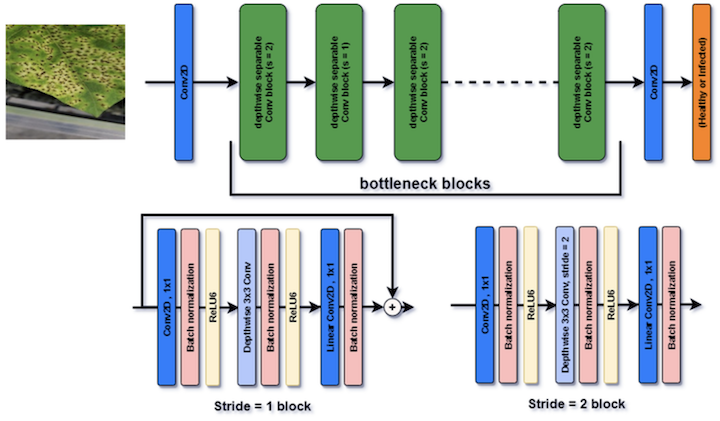


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
